In [1]:
import pandas as pd
import numpy as np
import os, re
data_path = "C:/Users/SpiffyApple/Documents/USC/OwnResearch/marketShare"

import matplotlib.pyplot as plt
%matplotlib inline
jet = plt.get_cmap('jet')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.regression.linear_model import WLS
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

import itertools

In [2]:
#convenience function
def toLatex(tmpDF, file_name, reg=False):
    with open("/".join([data_path,file_name]), 'w+') as f:
        if reg==False:
            f.write(tmpDF.to_latex())
        if reg:
            f.write(tmpDF.as_latex())
    return(tmpDF)

def toExcel(tmpDF, file_name):
    tmpDF.to_excel("/".join([data_path,file_name]))
    return(tmpDF)

# Milwaukee Tax Assessor data

City-wide data were sourced from the Milwaukee city [website](https://city.milwaukee.gov/DownloadTabularData3496.htm). Two files are used, the 1) MPROP([documentation](https://itmdapps.milwaukee.gov/gis/mprop/Documentation/mprop.pdf)) and 2) MAI which contains data on the number of units, land use, residential vs commercial etc.

Other potentially useful data sources can be obtained [here](https://city.milwaukee.gov/data)

Information on Milwaukee residential [zoning](https://city.milwaukee.gov/ImageLibrary/Groups/ccClerk/Ordinances/Volume-2/CH295-sub5.pdf) but more succintly [here](https://city.milwaukee.gov/Designguidelines/UrbanDesignResources/Zoning-Districts.htm). For all zoning codes, come [here](https://city.milwaukee.gov/PlanningPermits/DCDzoninglink.htm)

2011-2015 5year sample ACS data for Milwaukee come from [Social Explorer](https://www.socialexplorer.com/tables/ACS2015_5yr/R11848037)

### Matching Assessor data to Tiger data

The Assessor data make tract and block codes available but they do not make the county fips available. As a result, the tract and block number combinations are not uniquely matched to the Tiger file for Wisconsin blocks. In order to remedy this, I remove all counties that are not within Milwaukee city. Milwaukee City has 3 counties in it: Milwaukee, Washington, and Waukesha. Their respective [codes](https://www.disc.wisc.edu/Codebooks/FIPScodesWI.htm) are 079; 131; 133

In [3]:
tigers = pd.read_excel("/".join([data_path, 'milwaukee_blocks.xls']))
#tigers = pd.read_csv("/".join([data_path,"MilwaukeeCountyTiger.csv" ]))

In [4]:
tigers.loc[:,'tractblock'] = tigers.TRACTCE10.astype(str) +"."+tigers.BLOCKCE10.astype(str)
print("Number of unique tractblocks in tigers file: %d" %tigers.tractblock.unique().shape[0])

Number of unique tractblocks in tigers file: 8060


In [5]:
# in order to improved matching between Tiger files and these data, I first exclude non-relevant counties
print("number of blocks in Wisconsin: %d" %tigers.shape[0])
print("number of blocks in relevant counties: %d" %tigers[(tigers.COUNTYFP10 == 79) | (tigers.COUNTYFP10 == 131) | (tigers.COUNTYFP10 == 133)].shape[0])
#tigers = tigers[(tigers.COUNTYFP10 == 79) | (tigers.COUNTYFP10 == 131) | (tigers.COUNTYFP10 == 133)]

print("Number of tract and block combinations in the Tiger data that are not unique: %d" %(tigers.tractblock).duplicated().sum())

number of blocks in Wisconsin: 8060
number of blocks in relevant counties: 8058
Number of tract and block combinations in the Tiger data that are not unique: 0


# Data Processing

In [6]:
## Load MPROP data
tax = pd.read_csv("/".join([data_path, 'mprop.csv']), low_memory=False) ## load assessor data
tax = tax.loc[:,~tax.isnull().all()] ## drop columns that are all NA

tax.drop(['TAX_DELQ','RAZE_STATUS','BI_VIOL'],axis=1, inplace=True) ## drop some of the columns with only one value
tax.columns = tax.columns.str.lower() ## make columns lower case

tax.dropna(subset=['geo_tract'],inplace=True)
tax.dropna(subset=['owner_name_1'],inplace=True)
tax.geo_tract = tax.geo_tract.astype(int)
tax.loc[:,'geo_blockgroup'] = tax.geo_block.str[:1]

tax.loc[:,'owner_name_1'] = tax.owner_name_1.str.strip()
tax.owner_name_1.replace(",","", regex=True, inplace=True)

tax.owner_name_1.replace("THE ", "", regex=True, inplace=True)

## combine the owner fields
tax.loc[:,'owner'] = (tax.owner_name_1+" "+tax.owner_name_2.astype(str)+" "+tax.owner_name_3.astype(str)).replace("nan",'',regex=True)


## LOAD MAI data - so far, there hasn't been any use for it
#mai = pd.read_csv("/".join([data_path, 'mai.csv']), low_memory=False)
#mai = mai.loc[:,~mai.isnull().all()]
#mai.columns = mai.columns.str.lower()

In [7]:
zoningRepl = {'LB3':'local business-urban','LB2':'local business-midUrban','LB1':'local business-suburban',
             'IM':'industrial mixed','C9C':'neighborhood retail','C9E':'major retail','C9F':'office and service',
             'C9G':'mixed activity','RM1':'multifamily residential','RM2':'multifamily residential',
              'RM3':'multifamily residential','RM4':'multifamily residential','RM5':'multifamily residential',
             'RM6':'multifamily residential','RM7':'multifamily residential',
             'RT1':'onetwo residential','RT2':'onetwo residential','RT3':'twofamily residential',
             'RT4':'mixed residential','RO1':'residential office','RO2':'residential office',
             'RS1':'singlefamily residential','RS2':'singlefamily residential','RS3':'singlefamily residential',
             'RS4':'singlefamily residential','RS5':'singlefamily residential','RS6':'singlefamily residential',
             'RB1':'regional business','RB2':'regional business'}
tax.zoning.replace(zoningRepl,inplace=True)

#tax.zoning.unique()

In [8]:
print("Number of obs and proportion with unknown zoning. Num: %d, Share: %.3f" %(tax.zoning.isnull().sum(),tax.zoning.isnull().sum()/tax.shape[0]))
print("Number of units whose zoning is not known: %d" %tax.loc[tax.zoning.isnull(), 'nr_units'].sum())

tax.dropna(subset=['zoning'], inplace=True)

Number of obs and proportion with unknown zoning. Num: 1073, Share: 0.007
Number of units whose zoning is not known: 0


In [9]:
tax.loc[:,'tractblock'] = tax.geo_tract.astype(str)+"."+tax.geo_block
print("Number of unique tract blocks before removal of non-residential properties: %d" %tax.tractblock.unique().shape[0])

Number of unique tract blocks before removal of non-residential properties: 7010


In [10]:
tax.loc[:,'residential'] = tax.zoning.str.contains("residential") | (tax.land_use_gp <5) & (tax.land_use_gp>0) & (tax.land_use_gp.notnull())
tax.merge(tigers, on='tractblock',how='left').groupby('GEOID10').residential.sum().to_csv("/".join([data_path, 'milwaukee_props_w_commercial.csv']))

C:\Users\SpiffyApple\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [11]:
## since we are not concerned with non-residential properties, I drop those here
print("All observations: %d" %tax.shape[0])

tax = tax.loc[tax.zoning.str.contains("residential") | (tax.land_use_gp <5) & (tax.land_use_gp>0) & (tax.land_use_gp.notnull())]
print("Residential observations: %d" %tax.shape[0])

All observations: 160301
Residential observations: 150510


In [12]:
print("Number of units: %d" %tax.nr_units.sum())

Number of units: 257453


In [13]:
## remove properties that are owned by City of Milwaukee or its departments
#tax = tax.loc[~tax.owner_name_1.str.contains("CITY OF MILW|AUTH |AUTHORITY"),:]

In [14]:
print("Number of unique owner addresses:")
tax.owner_mail_addr =tax.owner_mail_addr.str.replace("# \d+|#|%",'').str.replace("P O","PO").str.replace(" AV,"," AVE").str.strip()
tax.owner_mail_addr.unique().shape[0]

Number of unique owner addresses:


114703

In [15]:
print("Number of unique owner The names:")
tax.owner_name_1.unique().shape[0]

Number of unique owner The names:


119625

In [16]:
#tax.owner_name_1[~tax.owner_name_1.duplicated()].sort_values()

In [17]:
ownernameRepl = {'W62N244 WASHINGTON AVE A105':'W62N244 WASHINGTON AVE','10 WHITE TRAIL LN':'10 WHITE TAIL LN',
               'W7026 COTTONVILLEDR':'W7026 COTTONVILLE DR','W7026 COTTTONVILLE DR':'W7026 COTTONVILLE DR',
                "DOOR4S DWELLINGS LLC":'DOORS DWELLINGS LLC'}
tax.owner_name_1.replace(ownernameRepl,inplace=True)

# Data Descriptives

In [18]:
## simple tabulation of owners and number of props each has
numPropsPerOwner = tax.loc[:,['owner_name_1','TAX_KEY']].groupby("owner_name_1").size()
numPropsPerOwner.name = 'numProperties'
numUnitsPerOwner = tax.loc[:,['owner_name_1','nr_units']].groupby("owner_name_1").sum()

pd.concat([numPropsPerOwner,numUnitsPerOwner],axis=1).sort_values('nr_units',ascending=False).head()

C:\Users\SpiffyApple\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,numProperties,nr_units
owner_name_1,,
HOUSING AUTHORITY OF THE,188,1593
CITY OF MILW,2367,1389
CITY OF MILW HOUSING AUTH,205,1323
METROPOLITAN ASSOCIATES FKA,10,1058
JUNEAU VILLAGE SHOPPING,1,598


In [19]:
#tax.loc[tax.owner_name_1.str.lower().str.contains("tarver"),['owner_name_1','owner_name_2','nr_units','own_ocpd','zoning','taxkey']]

In [20]:
print("share of units not owner occupied: %.2f" %(tax.own_ocpd.isnull().sum()/tax.own_ocpd.shape[0]))

share of units not owner occupied: 0.38


In [21]:
## share of units owner occupied and have more than one unit -- indeed
print("Share of owner-occupied properties with more than 1 unit: %.2f" %((tax.own_ocpd.notnull() & (tax.nr_units > 1)).sum()/tax.own_ocpd.shape[0]))

Share of owner-occupied properties with more than 1 unit: 0.11


In [22]:
## per Milwaukee website, this building has 49 units; not 491
tax.nr_units.replace(491, 49, inplace=True)
tax.nr_units.replace(391,39,inplace=True)

In [23]:
## look at the distribution of units and distribution of units owner occupied
tax[tax.nr_units>0].nr_units.describe()

count    144099.000000
mean          1.781130
std           5.806126
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         598.000000
Name: nr_units, dtype: float64

In [24]:
tax.loc[tax.nr_units>200,['owner','zoning','land_use_gp','house_nr_hi','street','nr_units']].head()

,owner,zoning,land_use_gp,house_nr_hi,street,nr_units
262,MIMG XL HARBOR POINTE SUB LLC,PD,3.0,7342,MARINE,372
1163,LUTHER HAVEN LLC,PD,3.0,8949,97TH,253
2086,7300 W DEAN LLC,PD,3.0,7500,DEAN,267
3011,WI ST JAMES ON FOUNTAIN LLC,PD,3.0,10590,FOUNTAIN,236
3741,BRADLEY PLACE TOWNHOMES LLC,multifamily residential,3.0,6411,BRADLEY,232


In [25]:
tax.loc[tax.nr_units> 0,['nr_units','owner_name_1','zoning']].groupby("owner_name_1").size().sort_values(ascending=False).head(n=20)

owner_name_1
CITY OF MILW                    794
CITY OF MILW HOUSING AUTH       175
HOUSING AUTHORITY OF THE        159
HOME PATH FINANCIAL LP          134
VILLAS EQUITY PARTNERS LLC      105
RBK MANAGEMENT                   70
PBR PROPERTIES LLC               70
NORTHSIDE HOMEOWNERS             69
PHOENIX SUN TERRACE VENTURE      69
TE I LLC                         62
DIVINE MOMENTUM REAL ESTATE      57
HVL97-MKE-2017-01 ICEMAN LLC     56
GUPTA PROPERTIES LLC             55
MUSKEGO VENTURES LLC             52
SUDDEN VALLEY LLC                52
CITY OF MILWAUKEE                51
GARDNER PROPERTIES               50
TE V LLC                         48
MOROCCO INVESTMENTS LLC          47
SCHULTZ REAL ESTATE LLC          45
dtype: int64

Text(0, 0.5, 'count censored above 1,000')

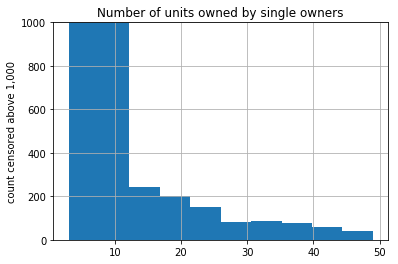

In [26]:
tax.nr_units[(tax.nr_units>2 ) & (tax.nr_units < 50)].hist()
plt.ylim(0,1000)
plt.title("Number of units owned by single owners")
plt.ylabel("count censored above 1,000")

In [27]:
print("Number of observations: %d" %tax.shape[0])
print("Number of duplicated owner names: %d" %tax.owner_name_1.duplicated().sum())
print("Number of duplicated owner addresses: %d" %tax.owner_mail_addr.duplicated().sum())
print("Number of duplicated owner addresses or names: %d" %(tax.owner_name_1.duplicated() | tax.owner_mail_addr.duplicated()).sum())
print("Smallest number of groups: %d" %(150510 - 42399))

Number of observations: 150510
Number of duplicated owner names: 30885
Number of duplicated owner addresses: 35807
Number of duplicated owner addresses or names: 42399
Smallest number of groups: 108111


In [28]:
## map names to addresses assuming that first address is correct
#s = tax.drop_duplicates('owner_mail_addr').set_index("owner_mail_addr")['owner_name_1']
#tax.loc[:,'name'] = tax['owner_mail_addr'].map(s)

#tax.loc[:,'name'].unique().shape[0]

In [29]:
## map names to addresses then addresses to names for consistency
s = tax.drop_duplicates('owner_name_1').set_index("owner_name_1")['owner_mail_addr']
tax.loc[:,'addr'] = tax['owner_name_1'].map(s)

k = tax.drop_duplicates('addr').set_index("addr")['owner_name_1']
tax.loc[:,'name'] = tax['addr'].map(k)

tax.loc[:,'addr'].unique().shape[0]

108529

### Method aside:
Ideally, I would capture both duplicated addresses and duplicated names depending on which one is duplicated. The problem is that, that's hard. The corresponding [stack](https://stackoverflow.com/questions/52865020/groupby-this-or-that) solutions, one of which was implemented, don't solve the problems. They get pretty close but still 400 owners off from the ideal answer and the ideal answer isn't even ideal due to inevitable remaining errors. In fact, Abhi's answers perform better than JPPs on this dataset **but** Abhi's doesn't preserve index and is more difficult to follow so I opt for JPPs. 

In [30]:
# implementation of stack overflow answers:

### Abhi's modified answer from chat:
## map owner_mail_addresses to owner_name_1s
#mapper = tax.groupby(['owner_name_1','owner_mail_addr'],as_index=False).sum().drop_duplicates('owner_name_1',keep='first').set_index('owner_name_1').owner_mail_addr
#tax.loc[:,'name1'] = tax.owner_name_1.map(mapper)

### Abhi's initial answer:
#tax.loc[:,'group'] = tax.groupby('owner_mail_addr').grouper.group_info[0]

#d = {'owner_name_1':'first','nr_units':'sum'}
#tax1 = tax.groupby('owner_name_1',as_index=False).sum().groupby('group').agg(d)
#tax1.sort_values('owner_name_1')
#tax1

# Herfindahl–Hirschman Index(HHI)

$$H = \sum_{i=1}^{N} s^2_i$$ where $i$ is a firm, $N$ is the total number of firms, and $H$ is the industry index. There are two ways to measure index: number of units and number of properties. In some cases, number of units is marked as 0 but number of properties owned by such owners (ie City of Milwaukee) can be quite large. The current preferred method is number of units. 

In [31]:
## city wide H index:
unitsSample = tax.loc[tax.nr_units>0,['nr_units','name']].groupby('name')

((unitsSample.sum()/unitsSample.ngroups)**2).sum()

nr_units    0.004505
dtype: float64

### Census Tract level index

In [32]:
print("Number of Census tracts in Milwaukee: %d" %tax.geo_tract.unique().shape[0])

Number of Census tracts in Milwaukee: 214


In [33]:
## group by owner and tract -> sum by owner and divide by num of units in tract -> square then sum by tract
tractsSample = tax.loc[tax.nr_units>0,['nr_units','name','geo_tract']].groupby(['geo_tract','name'])
tractsSampleProps = tax.loc[tax.nr_units>0,['taxkey','name','geo_tract']].groupby(['geo_tract','name'])

In [34]:
## compute shares and sum squares by tract then select areas with more than 1 property
sharesByTract =(tractsSample.sum()/tractsSample.sum().groupby(level=0).transform('sum'))
tractHI =  (sharesByTract**2).groupby(level=0).sum()[tractsSampleProps.size().groupby(level=0).sum()>=2]

Number of tracts with over 10 units: 213
Number of tracts with concentration over .2: 3


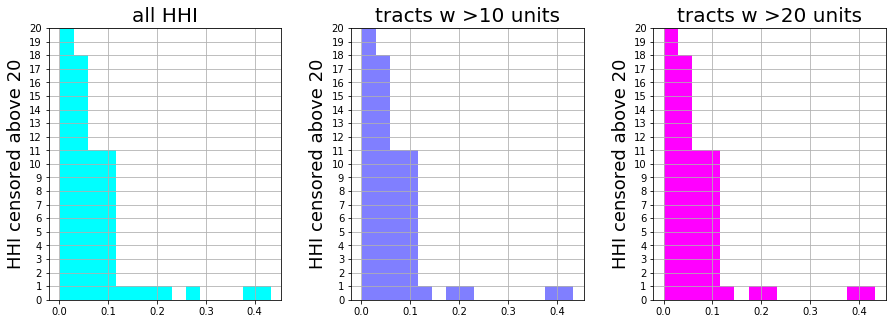

In [35]:
fig, axes = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

plasma = plt.get_cmap("cool")
colors = iter(plasma(np.linspace(0,1,len(axes.flatten()))))

tractHI.hist(bins=15,ax=axes[0], color=next(colors))
tractHI[tractsSample.sum().groupby(level=0).sum()>10].hist(bins=15,ax=axes[1], color=next(colors))
tractHI[tractsSample.sum().groupby(level=0).sum()>20].hist(bins=15,ax=axes[2], color=next(colors))

for ax,title in zip(axes.flatten(),['all HHI','tracts w >10 units', 'tracts w >20 units']):
    ax.set_ylim(0,20)
    ax.set_ylabel("HHI censored above 20", fontsize = 18)
    ax.set_title(title, fontsize = 20)
    ax.set_yticks(np.arange(0,21,1))

print("Number of tracts with over 10 units: %d" %tractHI[tractsSample.sum().groupby(level=0).sum()>10].shape[0])        
print("Number of tracts with concentration over .2: %d" %(tractHI[tractsSample.sum().groupby(level=0).sum()>10]>=.2).sum())     
    
plt.savefig("/".join([data_path, 'HHI_tract.png']))    

As can be seen between the 2 histograms immediately above, if there is any concentraion in market at the tract level, it seems it is due to census tracts with small number of units. However, once we exclude tracts with less than 10 units, it seems HHI stabilizes. 

### Census Block Group level index

In [36]:
tax['tractblockgroup'] = tax.geo_tract.astype(str)+"."+tax.geo_blockgroup.astype(str)
print("Number of unique block groups: %d" %tax.tractblockgroup.unique().shape[0])

Number of unique block groups: 580


In [37]:
groupSample = tax.loc[tax.nr_units>0,['nr_units','name','tractblockgroup']].groupby(['tractblockgroup','name'])

groupSampleProps = tax.loc[tax.nr_units>0,['taxkey','tractblockgroup']].groupby(['tractblockgroup']).size() #find number of props in block group
sharesByGroup =(groupSample.nr_units.sum()/groupSample.nr_units.sum().groupby(level=0).transform('sum'))
groupsHI =  pd.concat([(sharesByGroup**2).groupby(level=0).sum(),groupSampleProps,groupSample.sum().groupby(level=0).sum()],axis=1,keys=['HHI','nrProps','nrUnits'])
groupsHI.columns = groupsHI.columns.droplevel(level=1)

Number of block groups with more than 1 property: 574
Number of groups with more than 10 units and 1 property with concentration over .2: 20


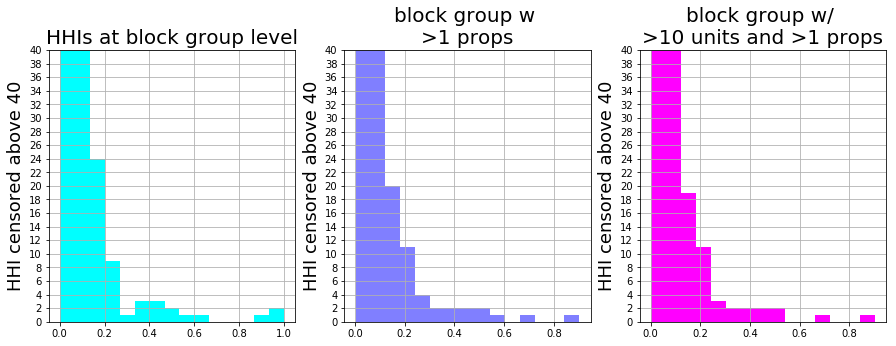

In [38]:
fig, axes = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

plasma = plt.get_cmap("cool")
colors = iter(plasma(np.linspace(0,1,len(axes.flatten()))))

groupsHI.HHI.hist(bins=15,ax=axes[0], color=next(colors))
groupsHI.loc[(groupsHI.nrProps>1),'HHI'].hist(bins=15,ax=axes[1], color=next(colors))
groupsHI.loc[(groupsHI.nrUnits>10) & (groupsHI.nrProps>1),'HHI'].hist(bins=15,ax=axes[2], color=next(colors))

for ax,title in zip(axes.flatten(),['HHIs at block group level','block group w \n>1 props', 'block group w/ \n>10 units and >1 props']):
    cens = 40
    ax.set_ylim(0,cens)
    ax.set_ylabel("HHI censored above %d" %cens, fontsize = 18)
    ax.set_title(title, fontsize = 20)
    ax.set_yticks(np.arange(0,42,2))
    
print("Number of block groups with more than 1 property: %d" %(groupsHI.nrProps>1).sum())
print("Number of groups with more than 10 units and 1 property with concentration over .2: %d" %(groupsHI[(groupsHI.nrUnits>10) & (groupsHI.nrProps>1)].HHI>=.2).sum())  
plt.savefig("/".join([data_path, 'HHI_blockgroup.png']))    

Census block group level is virtually the same as census tract level though not surprisingly since once is only twice as small as the other. As before, excluding small number of units seems to fix things a bit 

### Census Block level index:

In [39]:
tax['tractblock'] = tax.geo_tract.astype(str)+"."+tax.geo_block.astype(str)
print("Number of unique blocks: %d" %tax.tractblock.unique().shape[0])

Number of unique blocks: 6241


In [40]:
## group by owner and block -> sum by owner and divide by num of units in tract -> square then sum by block
blocksSample = tax.loc[tax.nr_units>0,['nr_units','name','tractblock']].groupby(['tractblock','name'])
blocksSampleProps = tax.loc[tax.nr_units>0,['taxkey','tractblock']].groupby(['tractblock']).size()

sharesByBlock =(blocksSample.sum()/blocksSample.sum().groupby(level=0).transform('sum'))
blocksHI =  pd.concat([(sharesByBlock**2).groupby(level=0).sum(), blocksSampleProps, blocksSample.sum().groupby(level=0).sum()], axis=1, keys = ['HHI','nrProps','nrUnits'])
blocksHI.columns = blocksHI.columns.droplevel(level=1)

Number of blocks with over 10 units: 5461
Number of blocks with HHI over .2: 580


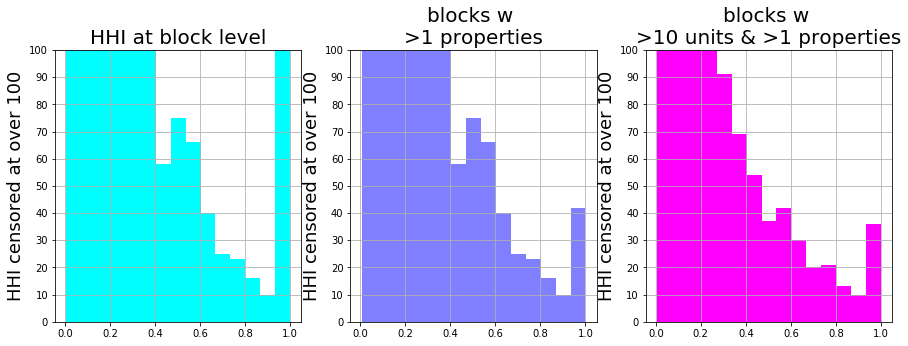

In [41]:
fig, axes = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

plasma = plt.get_cmap("cool")
colors = iter(plasma(np.linspace(0,1,len(axes.flatten()))))

blocksHI.HHI.hist(bins=15,ax=axes[0], color=next(colors))
blocksHI[blocksHI.nrProps>1].HHI.hist(bins=15,ax=axes[1], color=next(colors))
blocksHI[(blocksHI.nrProps>1) & (blocksHI.nrUnits>10)].HHI.hist(bins=15,ax=axes[2], color=next(colors))

for ax,title in zip(axes.flatten(),['HHI at block level','blocks w \n>1 properties', 'blocks w \n>10 units & >1 properties']):
    cens = 100
    ax.set_ylim(0,cens)
    ax.set_ylabel("HHI censored at over %d" %cens, fontsize =18)
    ax.set_title(title, fontsize = 20)
    ax.set_yticks(np.arange(0,110,10))
    
print("Number of blocks with over 10 units: %d" %((blocksHI.nrProps>1) & (blocksHI.nrUnits>10)).sum() )   
print("Number of blocks with HHI over .2: %d" %((blocksHI.HHI>=.2) &  (blocksHI.nrProps>1) & (blocksHI.nrUnits>10)).sum())    
plt.savefig("/".join([data_path, 'HHI_block.png']))    

In [42]:
print("largest owners in high concentration blocks")
HighContrBlocks = blocksHI.HHI[blocksHI.HHI>.9].index
toLatex(blocksSample.sum().reset_index(level=1).loc[HighContrBlocks].sort_values('nr_units',ascending=False).head(n=15),"largestOwners.tex")

largest owners in high concentration blocks


,name,nr_units
tractblock,,
11300.1005,PRESIDIO SQUARE APTS LLC,390
20100.3016,CITY OF MILWAUKEE,325
187000.1010,PRESIDIO SQUARE APTS LLC,274
900.2007,6800 TEUTONIA CORPORATION,264
800.1007,PRESIDIO SQUARE APTS LLC,248
2300.4000,CITY OF MILW,246
21300.1000,COVENANT COMMUNITIES INC,242
14700.1001,NORTHSIDE NEIGHBORHOOD,239
202.3015,WI ST JAMES ON FOUNTAIN LLC,236


In [43]:
blocksHI.loc[(blocksHI.HHI>.9),:].head(n=15)
## Many of the high HHIs correspond with only 1 property on the block

,HHI,nrProps,nrUnits
tractblock,,,
1000.1000,1.0,1,4
1000.1012,1.0,5,5
101.1003,1.0,1,72
102.2000,1.0,1,1
102.2009,1.0,1,1
10700.2017,1.0,1,46
10700.2025,1.0,2,114
10800.1000,1.0,1,1
10800.1002,1.0,1,12


In [44]:
print("Of HHIs equal to 1, proportion with only 1 property: %.2f" %(((blocksHI.HHI ==1) & (blocksHI.nrProps==1)).sum()/(blocksHI.HHI== 1).sum()))
print("Of HHIs greater than 20%%, proportion with only 1 property: %.2f" %(((blocksHI.HHI >.2) & (blocksHI.nrProps==1)).sum()/(blocksHI.HHI >.2).sum()))

Of HHIs equal to 1, proportion with only 1 property: 0.86
Of HHIs greater than 20%, proportion with only 1 property: 0.18


Same as the tract level, HHI is inflated when blocks with very few units is included but once we restrict to blocks with more than 10 units, HHI seems to stablize. 

## Attach ACS data

In [45]:
## remove block groups and blocks with less than 10 units
#groupsHI = groupsHI[groupSample.sum().groupby(level=0).sum()>=10]
#blocksHI = blocksHI[blocksSample.sum().groupby(level=0).sum()>=10]

In [46]:
## load ACS data and examine tracts/block groups where there are high shares of low income households, blacks, or renters
block = pd.read_csv("/".join([data_path, '2010 Census Block Data Milwaukee.csv']))
group = pd.read_csv("/".join([data_path, '2011-2015 ACS block group Milwaukee.csv']))
groupRents = pd.read_csv("/".join([data_path, '2011-2015 ACS block group rents Milwaukee.csv']))

group.columns = group.columns.str.lower().str.replace(":|,",'')
block.columns = block.columns.str.lower().str.replace(":|,",'')
groupRents.columns = groupRents.columns.str.lower().str.replace(":|,|\$","")

block.drop(['area name-legal/statistical area description', 'qualifying name',
       'area (land)', 'area (water)', 'summary level', 'geographic component',
       'region', 'division', 'fips', 'state (fips)', 'county'],axis=1,inplace=True)

group.drop(['fips'],inplace=True,axis=1)

block.columns = block.columns.str.replace("\([\w\s\.]+\)|\.1",'').str.strip()
group.columns = group.columns.str.replace("\([\w\s\.]+\)|\.1",'').str.strip()

block.loc[:,'blockgroup'] = block.block.astype(str)[:1]

block = block.loc[:,~block.columns.duplicated()]
group = group.loc[:,~group.columns.duplicated()]
block.loc[:,'tractblock'] = block.loc[:,'census tract'].astype(str)+"."+block.loc[:,'block'].astype(str)

In [47]:
print("Number of housing units according to Census blocks: %d" %block.loc[:,'housing units'].sum())

Number of housing units according to Census blocks: 418053


In [48]:
## merge block level data to block level HHI

blocksHI = blocksHI.merge(block, left_index=True, right_on='tractblock',how='left')

In [49]:
blocksHI['propBlack'] = np.divide(blocksHI.loc[:,'total population black or african american alone'],blocksHI.loc[:,'total population'])
blocksHI['propOver65'] = np.divide(blocksHI.loc[:,'total population 65 and over'],blocksHI.loc[:,'total population'])
blocksHI['propRent'] = np.divide(blocksHI.loc[:,'occupied housing units renter occupied'],blocksHI.loc[:,'occupied housing units'])
blocksHI['propVacant'] = np.divide(blocksHI.loc[:,'housing units vacant'],blocksHI.loc[:,'housing units'])

C:\Users\SpiffyApple\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\SpiffyApple\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\SpiffyApple\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\SpiffyApple\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [50]:
#drop blocks with unavialable census tract or block data
blocksHI = blocksHI[(blocksHI.block.notnull() & blocksHI.loc[:,'census tract'].notnull())]

In [51]:
blocksHI.loc[:,'housing units'].quantile([0,.1,.25,.5,.75,.9,1])

0.00       0.0
0.10      11.0
0.25      21.0
0.50      32.0
0.75      47.0
0.90      71.0
1.00    1622.0
Name: housing units, dtype: float64

In [52]:
print("Number of properties with no housing units: %d" %(blocksHI.loc[:,'housing units'] == 0).sum())

Number of properties with no housing units: 83


In [53]:
print("HHI and population for blocks with 0 housing units:")
blocksHI.loc[(blocksHI.loc[:,'housing units'] == 0),['HHI','total population']].sort_values('total population',ascending=False).head()

HHI and population for blocks with 0 housing units:


,HHI,total population
13113,1.000,78.0
31,1.000,0.0
6832,1.000,0.0
1410,1.000,0.0
266,0.125,0.0


In [54]:
print("Maybe remove HHIs with 0 population or housing units")

Maybe remove HHIs with 0 population or housing units


In [55]:
blocksHI.columns

Index(['HHI', 'nrProps', 'nrUnits', 'census tract', 'block',
       'total population', 'population density', 'area',
       'total population under 18 years', 'total population 18 to 34 years',
       'total population 35 to 64 years', 'total population 65 and over',
       'median age', 'median age male', 'median age female',
       'total population white alone',
       'total population black or african american alone',
       'total population american indian and alaska native alone',
       'total population asian alone',
       'total population native hawaiian and other pacific islander alone',
       'total population some other race alone',
       'total population two or more races', 'housing units',
       'occupied housing units', 'occupied housing units owner occupied',
       'occupied housing units renter occupied', 'housing units occupied',
       'housing units vacant', 'blockgroup', 'tractblock', 'propBlack',
       'propOver65', 'propRent', 'propVacant'],
      dtyp

## Analysis 

In [56]:
# upload Tiger file, merge across tracts and blocks so my data have GEOID10 IDs that can be matched to shape files
toMap = blocksHI.merge(tigers, left_on = ['census tract','block'], right_on = ['TRACTCE10', 'BLOCKCE10'],how='outer')
toMap.columns = toMap.columns.str.title().str.replace(" ","")
toMap.to_csv("/".join([data_path,'blocksHHI.csv']))
toMap.to_excel("/".join([data_path, "blocksHHI.xlsx"]))

In [57]:
toMap.TotalPopulation.dropna().quantile([0,.25,.5,.75,1])

0.00       0.0
0.25      49.0
0.50      77.0
0.75     116.0
1.00    2172.0
Name: TotalPopulation, dtype: float64

In [58]:
## merge block group level data to group level HHI 
group.loc[:,'tractgroup'] = group.loc[:,'census tract'].astype(str)+"."+group.loc[:,'block group'].astype(str)
groupRents.loc[:,'tractgroup'] = groupRents.loc[:,'census tract'].astype(str)+"."+groupRents.loc[:,'block group'].astype(str)

groupsHI = groupsHI.merge(group, left_index=True, right_on= 'tractgroup', how='left').merge(groupRents, how='left',on='tractgroup')

In [59]:
#groupsHI.rename(columns = {"nr_units":'hhi'},inplace=True)

In [60]:
groupsHI['propBlack'] = np.divide(groupsHI.loc[:,'total population black or african american alone'],groupsHI.loc[:,'total population'])
groupsHI['propOver65'] = np.divide(groupsHI.loc[:,'total population 65 and over'],groupsHI.loc[:,'total population'])
groupsHI['propRent'] = np.divide(groupsHI.loc[:,'occupied housing units renter occupied'],groupsHI.loc[:,'occupied housing units'])
groupsHI['propVacant'] = np.divide(groupsHI.loc[:,'housing units vacant'],groupsHI.loc[:,'housing units'])
groupsHI['unemployment'] = np.divide(groupsHI.loc[:,'population 16 years and over in labor force civilian unemployed'],groupsHI.loc[:,'population 16 years and over in labor force civilian',])
groupsHI['unitsPerPerson'] = np.divide(groupsHI.loc[:,'total population'],groupsHI.loc[:,'housing units'])

In [62]:
rentDistr = np.divide(groupsHI[['renter-occupied housing units with cash rent less than 300',
       'renter-occupied housing units with cash rent 300 to 599',
       'renter-occupied housing units with cash rent 600 to 799',
       'renter-occupied housing units with cash rent 800 to 999',
       'renter-occupied housing units with cash rent 1000 to 1249',
       'renter-occupied housing units with cash rent 1250 to 1499',
       'renter-occupied housing units with cash rent 1500 to 1999',
       'renter-occupied housing units with cash rent 2000 or more']],groupsHI['renter-occupied housing units with cash rent'].values.reshape(groupsHI.shape[0],1))

rentDistr.columns = rentDistr.columns.str.replace("renter-occupied housing units with cash ",'')

rentDistrCols = rentDistr.columns
#groupsHI = pd.concat([groupsHI, rentDistr],axis=1)

## most prevalent rent range in the data:
rentDistr.idxmax(axis=1).mode()

C:\Users\SpiffyApple\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


0    rent 600 to 799
dtype: object

In [63]:
groupsHousing = pd.read_excel("/".join([data_path, '2012-2016blockGroupACS.xlsx']))
groupsHousing.columns = groupsHousing.columns.str.replace("'|\$|,|\:|\-|Occupied|Housing|Units|Cash| Rent|with |\([\w\s]+\)","").str.replace("  "," ").str.strip().str.lower()
groupsHousing.columns = groupsHousing.columns.str.replace(" ","_")

In [64]:
groupsHI = groupsHI.merge(groupsHousing, left_on = ['census tract_x','block group_x'], right_on= ['census_tract', 'block_group'],how='left')

In [65]:
groupsHI.loc[:,'propCheap'] = np.divide(groupsHI['households_10000_to_14999']+groupsHI['households_less_than_10000'],groupsHI['households'])

In [66]:
groupsHI.rename(columns={'median gross rent':"medianGrossRent"},inplace=True)

## Relationship between HI index and Geographical Characteristics

In [71]:
outDict = {} 
regDict = {}

for x in ['np.log(median_value)','propCheap','propBlack','propRent','propVacant','medianGrossRent','propOver65','unitsPerPerson']:
    form = "HHI~{}".format(x)
    regDict[x] = smf.ols(formula=form, data=groupsHI.loc[(groupsHI.nrProps>1) & (groupsHI.nrUnits>9)]).fit()
    cont = regDict[x]
    inc = x
    numObs = 'numObs'
    outDict[x] = {'fitcoef': "%.04f (%.03f)" %(cont.params[inc].round(3), cont.pvalues[inc]), 
                    'nObs':cont.nobs,
                    'R^2 adj':cont.rsquared_adj.round(3)}
    
regTbl = pd.DataFrame(outDict).loc[['fitcoef','R^2 adj','nObs']]

In [74]:
toLatex(regTbl.transpose(),'blockGroupRegressions.tex')

,fitcoef,R^2 adj,nObs
np.log(median_value),0.0090 (0.151),0.002,532
propCheap,0.1700 (0.000),0.101,571
propBlack,0.0050 (0.585),-0.001,571
propRent,0.1430 (0.000),0.161,571
propVacant,-0.0150 (0.667),-0.001,571
medianGrossRent,-0.0000 (0.000),0.022,554
propOver65,0.0230 (0.634),-0.001,571
unitsPerPerson,0.0090 (0.015),0.009,571


For block groups with more than 1 property:


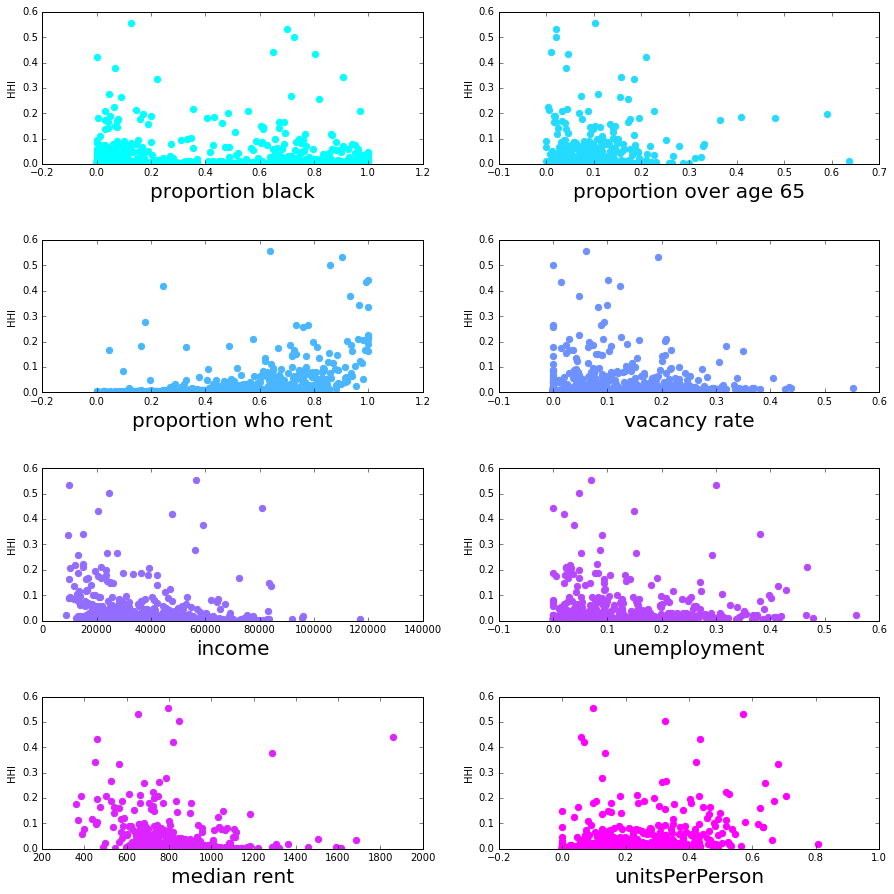

In [102]:
fig, axes = plt.subplots(4,2)
fig.set_figheight(15)
fig.set_figwidth(15)

plasma = plt.get_cmap("cool")
colors = iter(plasma(np.linspace(0,1,len(axes.flatten()))))
dotSize = 40
fontSize = 20

groupsHI= groupsHI.loc[groupsHI.nrUnits>1]

axes[0,0].scatter(x=groupsHI.propBlack,y=groupsHI.HHI,  s=dotSize, color = next(colors))
axes[0,1].scatter(x=groupsHI.propOver65, y= groupsHI.HHI, s=dotSize, color = next(colors))
axes[1,0].scatter(x=groupsHI.propRent, y=groupsHI.HHI, s=dotSize, color=next(colors))
axes[1,1].scatter(x=groupsHI.propVacant, y=groupsHI.HHI, s=dotSize, color=next(colors))
axes[2,0].scatter(x=groupsHI.loc[:,'median household income'],y=groupsHI.HHI, s=dotSize, color=next(colors))
axes[2,1].scatter(x = groupsHI.unemployment, y=groupsHI.HHI,s=dotSize, color=next(colors) )
axes[3,0].scatter(x = groupsHI.loc[:,'medianGrossRent'], y = groupsHI.HHI, s=dotSize, color=next(colors))
axes[3,1].scatter(x = groupsHI.loc[:,'propCheap'], y = groupsHI.HHI, s=dotSize, color=next(colors))

for ax,xlab in zip(axes.flatten(),['proportion black','proportion over age 65','proportion who rent','vacancy rate','income','unemployment','median rent', 'unitsPerPerson']):
    ax.set_ylim([0,.6])
    #ax.set_xlim([-0.01,1.01])
    ax.set_ylabel("HHI")
    ax.set_xlabel(xlab, fontsize = fontSize)
    #ax.set_title(xlab + " at block groups", fontsize = fontSize+1)
    
fig.subplots_adjust(hspace=.5)    
print("For block groups with more than 1 property:")
#plt.savefig("/".join([data_path,'blockGroups_acs.png']))

In [105]:
outDict = {} 
regDict = {}

blocksHI = blocksHI.loc[(blocksHI.nrProps>1) & (blocksHI.nrUnits>9)]

for x in ['propBlack','propRent','propVacant','propOver65']:
    form = "HHI~{}".format(x)
    regDict[x] = smf.ols(formula=form, data=blocksHI.loc[(blocksHI.nrProps>1) & (blocksHI.nrUnits>9)]).fit()
    cont = regDict[x]
    inc = x
    numObs = 'numObs'
    outDict[x] = {'fitcoef': "%.04f (%.03f)" %(cont.params[inc], cont.pvalues[inc]), 
                    'nObs':cont.nobs,
                    'R^2 adj':cont.rsquared_adj}
    
regTbl = pd.DataFrame(outDict).loc[['fitcoef','R^2 adj','nObs']]
toLatex(regTbl,'blockRegressions.tex')

,propBlack,propOver65,propRent,propVacant
fitcoef,0.0213 (0.000),-0.0472 (0.056),0.2447 (0.000),0.1976 (0.000)
R^2 adj,0.00314936,0.000482607,0.254135,0.0163706
nObs,5497,5497,5496,5498


For blocks with more than 1 property and 10 units


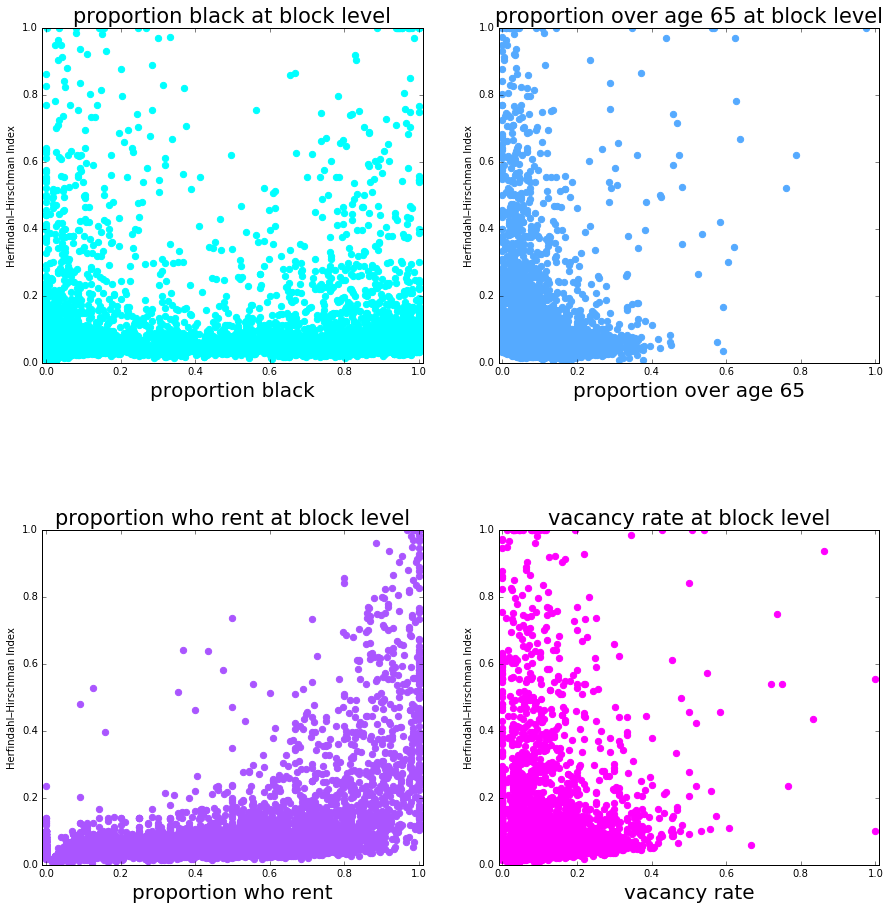

In [71]:
fig, axes = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(15)

plasma = plt.get_cmap("cool")
colors = iter(plasma(np.linspace(0,1,len(axes.flatten()))))
dotSize = 40
fontSize = 20

blocksHI = blocksHI.loc[(blocksHI.nrProps>1) & (blocksHI.nrUnits>9)]
axes[0,0].scatter(x=blocksHI.propBlack,y=blocksHI.HHI,  s=dotSize, color = next(colors))
axes[0,1].scatter(x=blocksHI.propOver65, y= blocksHI.HHI, s=dotSize, color = next(colors))
axes[1,0].scatter(x=blocksHI.propRent, y=blocksHI.HHI, s=dotSize, color=next(colors))
axes[1,1].scatter(x=blocksHI.propVacant, y=blocksHI.HHI, s=dotSize, color=next(colors))

for ax,xlab in zip(axes.flatten(),['proportion black','proportion over age 65','proportion who rent','vacancy rate']):
    ax.set_ylim([0,1])
    ax.set_xlim([-0.01,1.01])
    ax.set_ylabel("Herfindahl–Hirschman Index")
    ax.set_xlabel(xlab, fontsize = fontSize)
    ax.set_title(xlab + " at block level", fontsize = fontSize+1)
    
fig.subplots_adjust(hspace=.5)        
print("For blocks with more than 1 property and 10 units")
plt.savefig("/".join([data_path, "blocks_acs.png"]))

# Geocode tax assessor

arcGIS [geocoding](https://developers.arcgis.com/python/guide/batch-geocoding/) directions are a mess and don't work half the time but, nevertheless, do the job after persistent effort. 

Basically, have to geocode all addresses. On the other hand, addresses are already assigned census tracts and census block numbers which alleviates most of the need to geocode the addresses. 

In [ ]:
#tax.lookupAddress.to_csv("/".join([data_path, 'addresses2geocode.csv']))

In [ ]:
from arcgis.gis import *
from arcgis.geocoding import geocode
#from arcgis.geometry import Point

from arcgis.gis import GIS
from arcgis.geocoding import get_geocoders, batch_geocode

gis = GIS("http://www.arcgis.com", "burinski_priceusc", "Disturb3")

# use the first of GIS's configured geocoders
geocoder = get_geocoders(gis)[0]
print("MaxBatchSize : " + str(geocoder.properties.locatorProperties.MaxBatchSize))
print("SuggestedBatchSize : " + str(geocoder.properties.locatorProperties.SuggestedBatchSize))

In [ ]:
def to_addrDict(x):
    addrDict = {
        'Street': " ".join([str(x['house_nr_hi']),x['street'],x['sttype']]).lower(),
        'City':"Milwaukee",
        'State':"WI",
        'Zone':str(x['geo_zip_code'])[:5]}
    return(addrDict)

def to_addrStr(x):
    s= " ".join([str(x['house_nr_hi']),x['street'],str(x['sttype']) + ",","Milwaukee, WI", str(x['geo_zip_code'])[:5]]).title()
    return(s)

def parse_geocode_results(results):
    #topres = [r for r in results if r['score']>99][0]['location']
    x = results[0]['location']['x']
    y = results[0]['location']['y']
    return((x,y))

def parse_batch_results(results):
    coordDict = {}
    coordDict['x'] = []
    coordDict['y'] = []
    for result in results:
        coordDict['x'].append(result['location']['x'])
        coordDict['y'].append(result['location']['y'])
    return(pd.DataFrame(coordDict))

In [ ]:
#make address string for all addresses in the data set
tax.loc[:,'lookupAddress'] = tax.apply(lambda r: to_addrStr(r),axis=1)

## geocode single address 
#results = geocode(addresses.iloc[0])
#parse_geocode_results(results)

## i can batch geocode the addresses OR code them individually. For one, I'll be charged, the other, I can get away with
#results = batch_geocode(list(addresses))
#parse_batch_results(results)

In [ ]:
## split my data frame into 200 parts
splitArray = np.array_split(tax.lookupAddress, int(tax.shape[0]/200))
len(splitArray)

In [ ]:
## batch geocode them in 200s until done
chunkResults = []
for i,chunk in enumerate(splitArray[0:]):
    if i%100 == 0:
        print("Working on chunk: %d" %i)
        #print("\tChunk size: %d" %chunk.shape[0])
    try:
        temp = parse_batch_results(batch_geocode(list(chunk)))
        temp.index = chunk.index
        chunkResults.append(temp)
    except RuntimeError as e:
        print(e)
        print("stopped at chunk num: %d" %i)
        break

In [ ]:
codedBatch = pd.concat(chunkResults)
codedBatch.to_csv("/".join([data_path, 'geocodedAddresses_4thBatch.csv']))

In [ ]:
## batch stopped working so I am now turning to geocode. 

chunkResults = []
for i,chunk in enumerate(splitArray[358:]):
    if i%10 == 0:
        print("Working on chunk: %d" %i)
        print("\tChunk size: %d" %chunk.shape[0])
    try:
        temp = chunk.apply(lambda s: parse_geocode_results(geocode(s)))
        temp.index = chunk.index
        temp = temp.apply(pd.Series)
        temp.columns = ['x','y']
        chunkResults.append(temp)
    except RuntimeError as e:
        print(e)
        print("stopped at chunk num: %d" %i)
        break

In [ ]:
print("Number of chunks processed: %d" %len(chunkResults))
codedBatch = pd.concat(chunkResults)
codedBatch.to_csv("/".join([data_path, 'geocodedAddresses_4thBatch.csv']))

In [ ]:
tempLoad = pd.read_csv("/".join([data_path, 'geocodedAddresses_3rdBatch.csv']))

In [ ]:
tempLoad.shape[0]

In [ ]:
9000/200

In [ ]:
358+45

In [ ]:
batchDict = {}

for s in ['geocodedAddresses_1stBatch.csv','geocodedAddresses_2stBatch.csv','geocodedAddresses_3rdBatch.csv']:
    batchDict[s] = pd.read_csv("/".join([data_path, s]))
    
batches = pd.concat(batchDict)    

In [ ]:
batches.set_index('Unnamed: 0',inplace=True)